In [1]:
import numpy as np
import pandas as pd
import scipy
from scipy import integrate
import matplotlib.pylab as pylab
import os
from functools import partial
import statsmodels.api as sm
lowess=sm.nonparametric.lowess
from scipy.interpolate import interp1d
from glob import iglob

# read data

In [2]:
files = iglob('./*for_maxwell_fitting*')
for file in files:
    print(file)

.\PS202k_for_maxwell_fitting_150oC.txt
.\PS202k_for_maxwell_fitting_150oC.xlsx
.\PS283k_for_maxwell_fitting_150oC.txt
.\PS283k_for_maxwell_fitting_150oC.xls
.\PS30k_for_maxwell_fitting_120oC.txt
.\PS30k_for_maxwell_fitting_120oC.xlsx
.\PS45k_for_maxwell_fitting_125oC.txt
.\PS45k_for_maxwell_fitting_125oC.xlsx
.\PS75k_for_maxwell_fitting_130oC.txt
.\PS75k_for_maxwell_fitting_130oC.xlsx
.\PS90k_for_maxwell_fitting_135oC.txt
.\PS90k_for_maxwell_fitting_135oC.xlsx


<Axes: xlabel='ωaT'>

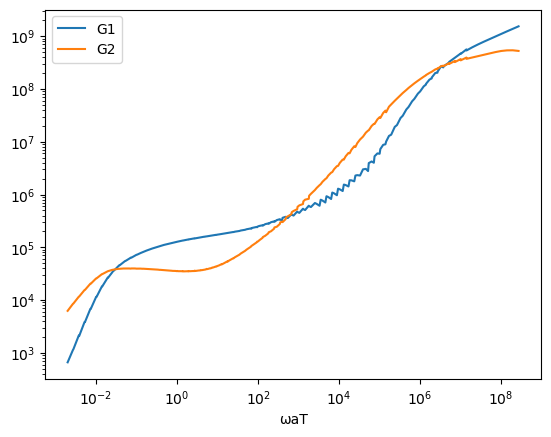

In [2]:
file = '.\PS283k_for_maxwell_fitting_150oC.xls'
df_experiment=pd.read_excel(file,index_col=0)
df_experiment=df_experiment.iloc[:,:]
df_experiment.plot(y=['G1','G2'],loglog=True)

In [3]:
#Maxell model
#ω=np.logspace(-3,4,50)
def maxwell(g,τd,ω):
    G1=ω*0
    G2=ω*0
    for τdi,gi in zip(τd,g):
        G1+=gi*ω**2*τdi**2/(ω**2*τdi**2+1)
        G2+=gi*ω*τdi/(ω**2*τdi**2+1)
    return (G1,G2)
def maxwell_for_fit(g_log,τd,ω,G1_exp,G2_exp):
    '''here should use the log10(g) to fit
    '''
    G1=ω*0
    G2=ω*0
    for τdi,gi in zip(τd,10**g_log):
        G1+=gi*ω**2*τdi**2/(ω**2*τdi**2+1)
        G2+=gi*ω*τdi/(ω**2*τdi**2+1)
    return np.hstack((np.log10(G1)-np.log10(G1_exp),np.log10(G2)-np.log10(G2_exp)))

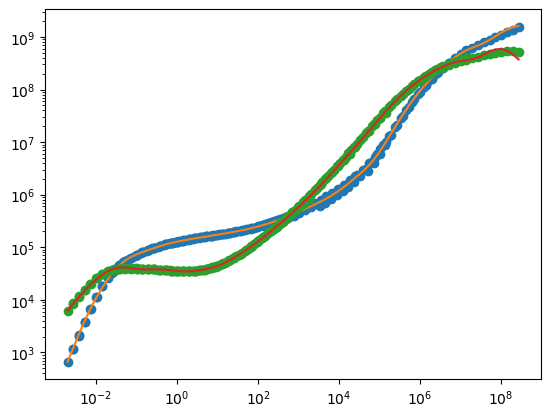

In [4]:
ω=df_experiment.index.values
τd=np.logspace(-8,2,20)
#τd=np.array([0.113])
g0_log=np.log10(1/τd**2)
least_squares=scipy.optimize.least_squares
res=least_squares(maxwell_for_fit,g0_log,args=(τd,ω,df_experiment.loc[:,'G1'],df_experiment.loc[:,'G2']))
g=10**res.x
G1,G2=maxwell(g,τd,ω)
pylab.loglog(df_experiment.loc[:,'G1'],'o',ω,G1,'-',df_experiment.loc[:,'G2'],'o',ω,G2,'-')
#pylab.loglog(df_experiment.loc[:,'G1'],'o')

#export data
file_path = os.path.splitext(file)[0]+".csv"
with open(file_path, mode="w") as file:
    file.write("taud,g\n")
    for ind,_ in enumerate(τd):
        line = "{},{}".format(τd[ind],g[ind])
        file.write(line + "\n")

# convert to stress growth $\eta^+(t)$

Upper-convected Maxwell Equation:

$$
\overset{\bigtriangledown }{\mathbf{\sigma}} +\frac{\mathbf\sigma}{\tau} = 2G \mathbf{D}
$$
here:
$$
\mathbf{D} = \frac{\nabla v+(\nabla v)^T}{2}
\\
for\ shear\ flow\ \mathbf{D} = \begin{pmatrix}
 0 & \frac{\dot{\gamma}}{2} & 0\\
 \frac{\dot{\gamma}}{2} & 0 & 0\\
 0 & 0 & 0
\end{pmatrix}
\\
\overset{\bigtriangledown }{\mathbf{\sigma}} \equiv \dot{\mathbf{\sigma}}-(\nabla v)^T\cdot\mathbf{\sigma} - \mathbf{\sigma}\cdot \nabla v
\\
\mathbf\sigma_0 = \begin{pmatrix}
 0 & 0 & 0\\
 0 & 0 & 0\\
 0 & 0 & 0
\end{pmatrix}
$$

In [59]:
def d_sigma(σ,shear_rate,τdi,gi):
    '''
    for simple shear.
    σ0 = np.array([[0,0,0],[0,0,0],[0,0,0]])
    κ = ∇𝑣 = np.array([[0,shear_rate,0],[0,0,0],[0,0,0]])
    '''
    κ = np.array([[0,shear_rate,0],[0,0,0],[0,0,0]])
    D = np.array([[0,shear_rate/2,0],[shear_rate/2,0,0],[0,0,0]])
    dσdt = np.dot(σ,κ) + np.dot(np.transpose(κ),σ) - σ/τdi + 2 * gi * D
    return dσdt

#the y is the ode fun variable, include A0 and λ0
#y0=np.concatenate((A0.flatten(),np.array([λ0])))
def fun_for_ode(t,y,shear_rate,τdi,gi):
    '''
    function used in the intergrate.solve_ivp()
    pack:
        y0 = σ0.flatten()
    unpack:
        σ = np.reshape(y,[3,3])
    '''
    σ = np.reshape(y,[3,3])
    dσdt = d_sigma(σ,shear_rate,τdi,gi)
    return dσdt.flatten()

<AxesSubplot:title={'center':'simple shear'}, xlabel='Time(s)', ylabel='Viscosity(Pa.s)'>

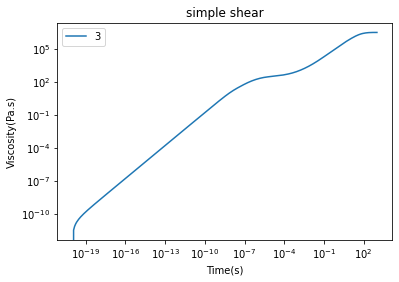

In [90]:
shear_rate = 1
t_span=[1E-20,1E3]
t_eval=np.logspace(-20,3,num=300)

y0 = np.zeros(9)
res_y = np.zeros([9,300])
for τdi,gi in zip(τd,g):
    fun=partial(fun_for_ode, shear_rate = shear_rate, τdi = τdi, gi = gi)
    res=integrate.solve_ivp(fun, t_span, y0, method='Radau',t_eval=t_eval)
    res_y += res.y
    
df = pd.DataFrame(res_y.T,index=res.t)/shear_rate
df.plot(y=3,loglog=True,\
        ylabel="Viscosity(Pa.s)",\
        xlabel="Time(s)",\
        title="simple shear")